In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/laba/графички'

In [ ]:
import numpy as np
import cv2 as cv2
from matplotlib import pyplot as plt
import matplotlib as mpl
cmap = mpl.colormaps['viridis']

def find_area(name):
  path = '/content/drive/MyDrive/Colab Notebooks/laba/графички/'
  img = cv2.imread(f'{path}'+f'{name}'+'.png')
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  print(img.shape)
  _, inputImg = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV)

  kernel = np.ones((7, 7))
  outputImg = cv2.dilate(inputImg, kernel)
  ret,thresh = cv2.threshold(outputImg,127,255,0)
  contours,hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, 2)
  contour_image = np.zeros_like(thresh)

  # Draw contours on the blank image
  cv2.drawContours(contour_image, contours, -1, (255, 255, 255), 2)

  # Display the original image with contours
  plt.figure(figsize=(10, 6))
  plt.imshow(contour_image)
  # plt.xticks([]), plt.yticks([])
  plt.show()

  cnt = contours[0]
  area = cv2.contourArea(cnt)
  return area, cnt, contour_image

(482, 330)


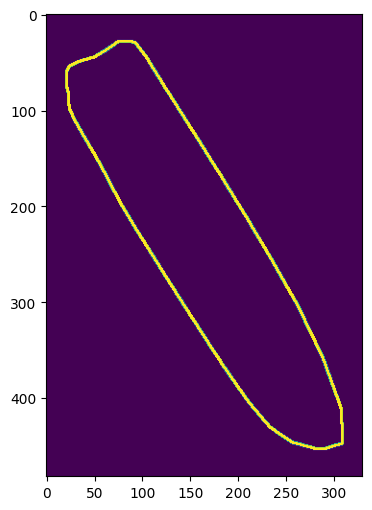

44654.0

In [ ]:
area, contour1, contour_image = find_area('yz')
area

In [ ]:
import math

-58.40798100685699


<ipython-input-128-c881030be1b3>:3: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box) # округление координат
<ipython-input-128-c881030be1b3>:8: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  edge1 = np.int0((box[1][0] - box[0][0],box[1][1] - box[0][1]))
<ipython-input-128-c881030be1b3>:9: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  edge2 = np.int0((box[2][0] - box[1][0], box[2][1] - box[1][1]))


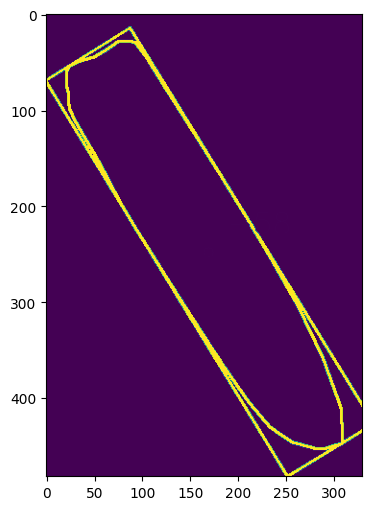

In [ ]:
rect = cv2.minAreaRect(contour1) # пытаемся вписать прямоугольник
box = cv2.boxPoints(rect) # поиск четырех вершин прямоугольника
box = np.int0(box) # округление координат
center = (int(rect[0][0]),int(rect[0][1]))
area = int(rect[1][0]*rect[1][1]) # вычисление площади

# вычисление координат двух векторов, являющихся сторонам прямоугольника
edge1 = np.int0((box[1][0] - box[0][0],box[1][1] - box[0][1]))
edge2 = np.int0((box[2][0] - box[1][0], box[2][1] - box[1][1]))

# выясняем какой вектор больше
usedEdge = edge1
if cv2.norm(edge2) > cv2.norm(edge1):
  usedEdge = edge2
reference = (1,0) # горизонтальный вектор, задающий горизонт

# вычисляем угол между самой длинной стороной прямоугольника и горизонтом
# angle = math.degrees(math.atan2(-usedEdge[1]+241, usedEdge[0]-165))
angle = -math.degrees(math.atan2(usedEdge[1], usedEdge[0]))
# angle = 180.0/math.pi * math.acos((reference[0]*usedEdge[0] + reference[1]*usedEdge[1]) / (cv2.norm(reference) *cv2.norm(usedEdge)))
print(angle)
# path = '/content/drive/MyDrive/Colab Notebooks/laba/графички/yz.png'
# img = cv2.imread(path)
img = contour_image.copy()
cv2.drawContours(img,[box],0,(255,0,0),2) # рисуем прямоугольник
cv2.circle(img, center, 5, 2) # рисуем маленький кружок в центре прямоугольника
# выводим в кадр величину угла наклона
cv2.putText(img, "%d" % int(angle), (center[0]+20, center[1]-20), cv2.FONT_HERSHEY_SIMPLEX, 1, 2)
plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.show()

In [ ]:
from numpy.linalg import eig, inv, svd
from math import atan2
import numpy as np


def __fit_ellipse(x, y):
    x, y = x[:, np.newaxis], y[:, np.newaxis]
    D = np.hstack((x * x, x * y, y * y, x, y, np.ones_like(x)))
    S, C = np.dot(D.T, D), np.zeros([6, 6])
    C[0, 2], C[2, 0], C[1, 1] = 2, 2, -1
    U, s, V = svd(np.dot(inv(S), C))
    a = U[:, 0]
    return a

def ellipse_center(a):
    b, c, d, f, g, a = a[1] / 2, a[2], a[3] / 2, a[4] / 2, a[5], a[0]
    num = b * b - a * c
    x0 = (c * d - b * f) / num
    y0 = (a * f - b * d) / num
    return np.array([x0, y0])

def ellipse_axis_length(a):
    b, c, d, f, g, a = a[1] / 2, a[2], a[3] / 2, a[4] / 2, a[5], a[0]
    up = 2 * (a * f * f + c * d * d + g * b * b - 2 * b * d * f - a * c * g)
    down1 = (b * b - a * c) * (
        (c - a) * np.sqrt(1 + 4 * b * b / ((a - c) * (a - c))) - (c + a)
    )
    down2 = (b * b - a * c) * (
        (a - c) * np.sqrt(1 + 4 * b * b / ((a - c) * (a - c))) - (c + a)
    )
    res1 = np.sqrt(up / down1)
    res2 = np.sqrt(up / down2)
    return np.array([res1, res2])

def ellipse_angle_of_rotation(a):
    b, c, d, f, g, a = a[1] / 2, a[2], a[3] / 2, a[4] / 2, a[5], a[0]
    return atan2(2 * b, (a - c)) / 2

def fit_ellipse(x, y):
    """@brief fit an ellipse to supplied data points: the 5 params
        returned are:

        M - major axis length
        m - minor axis length
        cx - ellipse centre (x coord.)
        cy - ellipse centre (y coord.)
        phi - rotation angle of ellipse bounding box

    @param x first coordinate of points to fit (array)
    @param y second coord. of points to fit (array)
    """
    a = __fit_ellipse(x, y)
    centre = ellipse_center(a)
    phi = ellipse_angle_of_rotation(a)
    M, m = ellipse_axis_length(a)
    # assert that the major axix M > minor axis m
    if m > M:
        M, m = m, M
    # ensure the angle is betwen 0 and 2*pi
    phi -= 2 * np.pi * int(phi / (2 * np.pi))
    return M, m, centre[0], centre[1], phi


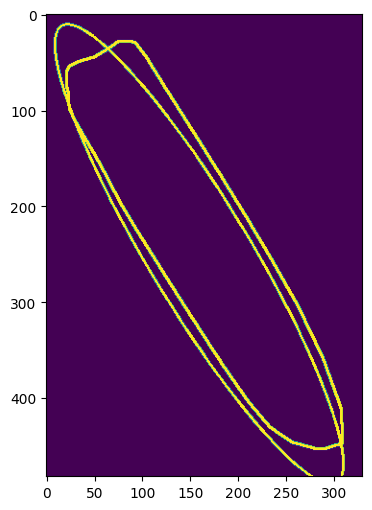

In [ ]:
points = np.empty([contour1.shape[0], 2])
for i in range (contour1.shape[0]):
  for j in range (2):
    points[i,j] = contour1[i,0,j]
points[:,1] = abs(points[:,1]-482)

# Разделяем координаты X и Y
x = points[:, 0]
y = points[:, 1]
M, m, center0, center1, phi = fit_ellipse(x, y)
center = (int(center0), int(center1))
startAngle = 0
axes = (int(M), int(m))
endAngle = 360

# Red color in BGR
color = (255, 255, 255)

# Line thickness of 5 px
thickness = 2
phi = -phi/math.pi*180
# Using cv2.ellipse() method
# Draw a ellipse with red line borders of thickness of 5 px
img = contour_image.copy()
image = cv2.ellipse(img, center, axes, phi, startAngle, endAngle, color, thickness)
plt.figure(figsize=(10, 6))
plt.imshow(image)
plt.show()